In [39]:
import time
import copy
import sys
from collections import OrderedDict
from collections import namedtuple
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import numpy as np
import torchvision
import  torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import random 
import pickle

In [224]:
#Configure GPU (change if not M1 mac)
mps = torch.device("mps")

In [7]:
# Datasets

# Using CIFAR-10 again as in the programming assignments
# Load training data
transform_train = transforms.Compose([                                   
    transforms.RandomCrop(32, padding=4),                                       
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                        download=True,
                                        transform=transform_train)

# Load testing data
transform_test = transforms.Compose([                                           
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True,
                                       transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
# Saving And helpers

def save_tracker(tracker, path):
  np.savetxt(path, tracker, delimiter=',') 

def save_trackers(device, filename):
  """Save all trackers and current total_time to a file."""
  torch.save((device['train_loss_tracker'], device['train_acc_tracker'], device['test_loss_tracker'], device['test_acc_tracker'], total_time), filename)
  print("Saved trackers to " + filename)

def moving_average(a, n=100):
  '''Helper function used for visualization'''
  ret = torch.cumsum(torch.Tensor(a), 0)
  ret[n:] = ret[n:] - ret[:-n]
  return ret[n - 1:] / n

# Plotting helpers! 
def make_plot(trackers, num_epochs, title, y_axis_lab, should_average=False, legend=True, fix_ax=True):
  avg_fn = moving_average if should_average else (lambda x : x) 
  x = np.arange(1, len(avg_fn(list(trackers.values())[0])) + 1)
  x = x / (len(x)/num_epochs)
  ax = plt.subplot(1,1,1)
  plt.title(title)
  plt.xlabel("Epoch")
  plt.ylabel(y_axis_lab)
  if fix_ax:
    ax.set_ylim([0, 100])
  # plt.xticks(np.arange(min(x), max(x)+1, 1))
  ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%1.0f'))

  for lab, t in trackers.items(): 
    l1, = ax.plot(x, avg_fn(t), label = lab)

  if legend:
    _ = plt.legend()
  plt.show()

def make_plot_better(trackers, num_epochs, title, y_axis_lab, should_average=False, n = 100):
  avg_fn = (lambda x : moving_average(x, n)) if should_average else (lambda x : x) 
  x = np.arange(1, len(avg_fn(list(trackers.values())[0])) + 1)
  x = x / (len(x)/num_epochs)
  ax = plt.subplot(1,1,1)
  plt.title(title)
  plt.xlabel("Epoch")
  plt.ylabel(y_axis_lab)
  # plt.xticks(np.arange(min(x), max(x)+1, 1))
  ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%1.0f'))

  for lab, t in trackers.items(): 
    l1, = ax.plot(x, avg_fn(t), label = lab)
  _ = plt.legend()
  plt.show()

In [9]:
class DatasetSplit(torch.utils.data.Dataset):
    def __init__(self, dataset, idxs):
        self.dataset = dataset
        self.idxs = [int(i) for i in idxs]

    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, item):
        image, label = self.dataset[self.idxs[item]]
        return image, torch.tensor(label)

def iid_sampler(dataset, num_devices, data_pct):
    '''
    dataset: PyTorch Dataset (e.g., CIFAR-10 training set)
    num_devices: integer number of devices to create subsets for
    data_pct: percentalge of training samples to give each device
              e.g., 0.1 represents 10%

    return: a dictionary of the following format:
      {
        0: [3, 65, 2233, ..., 22] // device 0 sample indexes
        1: [0, 2, 4, ..., 583] // device 1 sample indexes
        ...
      }

    iid (independent and identically distributed) means that the indexes
    should be drawn independently in a uniformly random fashion.
    '''
    total_samples = len(dataset)
    sampled = {}
    number_samples = int((data_pct)*(total_samples)) 

    for i in range(num_devices):
      sampled[i] = random.sample(range(total_samples), number_samples)
        
    return sampled

In [10]:
# Neural net definitions

# Same ConvNet as in Assignment 2 and 3
def conv_block(in_channels, out_channels, kernel_size=3, stride=1,
               padding=1):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding,
                  bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
        )

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.model = nn.Sequential(
            conv_block(3, 32),
            conv_block(32, 32),
            conv_block(32, 64, stride=2),
            conv_block(64, 64),
            conv_block(64, 64),
            conv_block(64, 128, stride=2),
            conv_block(128, 128),
            conv_block(128, 256),
            conv_block(256, 256),
            nn.AdaptiveAvgPool2d(1)
            )

        self.classifier = nn.Linear(256, 10)

    def forward(self, x):
        h = self.model(x)
        B, C, _, _ = h.shape
        h = h.view(B, C)
        return self.classifier(h)

In [25]:
# Federated learning helpers

# The baseline `average' function. 
def average_weights(devices):
    '''
    devices: a list of devices generated by create_devices
    Returns an the average of the weights.
    '''
    state_dicts = [device['net'].state_dict() for device in devices]
    max_magnitude = 0
    # initialize w_avg to tensors from device 0
    w_avg = copy.deepcopy(state_dicts[0])
    for k in w_avg.keys():
      w_avg[k] = w_avg[k].type(torch.float32)

    # for each model param
    for k in w_avg.keys():
        # for each remaining device i, add tensor state_dicts[i][k] to w_avg[k]
        for i in range(1, len(devices)):
            max_magnitude = max(max_magnitude, abs(torch.max(state_dicts[i][k].type(torch.float32))))
            w_avg[k] += (state_dicts[i][k].type(torch.float32))
        # compute average
        w_avg[k] /= float(len(devices))
    return w_avg, max_magnitude


def get_devices_for_round(devices, device_pct):  
    return random.sample(devices, int(device_pct * len(devices)))

def create_device(net, device_id, trainset, data_idxs, lr=0.1,
                  milestones=None, batch_size=128):
    if milestones == None:
        milestones = [25, 50, 75]

    device_net = copy.deepcopy(net)
    optimizer = torch.optim.SGD(device_net.parameters(), lr=lr, momentum=0.9)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,
                                                     milestones=milestones,
                                                     gamma=0.1)
    device_trainset = DatasetSplit(trainset, data_idxs)
    device_trainloader = torch.utils.data.DataLoader(device_trainset,
                                                     batch_size=batch_size,
                                                     shuffle=True)
    return {
        'net': device_net,
        'id': device_id,
        'dataloader': device_trainloader, 
        'optimizer': optimizer,
        'scheduler': scheduler,
        'train_loss_tracker': [],
        'train_acc_tracker': [],
        'test_loss_tracker': [],
        'test_acc_tracker': [],
        }

In [26]:
# Local device training and testing
def train(epoch, device, criterion):
    device['net'].train()
    train_loss, correct, total = 0, 0, 0
    for batch_idx, (inputs, targets) in enumerate(device['dataloader']):
        inputs, targets = inputs.to(mps), targets.to(mps)
        device['optimizer'].zero_grad()
        outputs = device['net'](inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        device['optimizer'].step()
        train_loss += loss.item()
        device['train_loss_tracker'].append(loss.item())
        loss = train_loss / (batch_idx + 1)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        acc = 100. * correct / total
        dev_id = device['id']
        sys.stdout.write(f'\r(Device {dev_id}/Epoch {epoch}) ' + 
                         f'Train Loss: {loss:.3f} | Train Acc: {acc:.3f}')
        sys.stdout.flush()
    device['train_acc_tracker'].append(acc)
    sys.stdout.flush()

def test(epoch, device, criterion):
    device['net'].eval()
    test_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(mps), targets.to(mps)
            outputs = device['net'](inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            device['test_loss_tracker'].append(loss.item())
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            loss = test_loss / (batch_idx + 1)
            acc = 100.* correct / total
    sys.stdout.write(f' | Test Loss: {loss:.3f} | Test Acc: {acc:.3f}\n')
    sys.stdout.flush()  
    acc = 100.*correct/total
    device['test_acc_tracker'].append(acc)



In [81]:
# Aggregation function tests (the main experiment routine)

# Given two different sets of aggregated weights, 
# gives a value representing the difference between them,
# as a way to measure the direct cost of using our aggregated function
def diff_aggregated_weights(strat, baseline):
    result = 0 
    for k in strat.keys():
        result += torch.linalg.norm(strat[k] - baseline[k])
    return result

# A data type for experiment results
BackdoorResult = namedtuple("BackdoorResult", ["scheme_loss", "test_accuracy", "backdoor_success", "devices", "avg_weight_history"])

# The main routine! 
def run_federated_test(agg_fn = (lambda x : average_weights(x)[0]),  # Pass in aggregation function, 
                                                  # Device list -> aggregated weights 
                       rounds = 10,               # Rounds of FL
                       local_epochs = 4,          # Epochs per device                      
                       num_devices = 50,          # Total # devices
                       device_pct = 0.1,          # % of devices per round
                       data_pct = 0.1,            # % of data each device gets
                       net = ConvNet().to(mps),   # Net design; make sure on mps
                       evil_round = None,         # If None, no attack; else attacker will mount attack on this round
                       attacker_strategy = None,  # device --> void --- set up the local weights on the attacker
                       evil_device_id = None,     # Which device attacks? 
                       evaluate_attack = None,    # Function devices --> <any> measuring how well the attack worked at the end
                       output_filename = None):   
                                                 
    
    criterion = nn.CrossEntropyLoss()
    data_idxs = iid_sampler(trainset, num_devices, data_pct)

    # Part 1.3: Implement device creation here
    devices = [create_device(net, i, trainset, data_idxs[i]) for i in range(num_devices)] # Implement this!
    
    scheme_loss = []
    max_magnitudes = []
    avg_weight_history = []

    ## IID Federated Learning
    start_time = time.time()
    for round_num in range(rounds):
        # Part 1.3: Implement getting devices for each round here
        round_devices = get_devices_for_round(devices, device_pct)

        print('Round: ', round_num)
        # Train locally 
        for device in round_devices:
            for local_epoch in range(local_epochs):
                train(local_epoch, device, criterion)
        
        # One device becomes evil if required
        if (evil_round and round_num == evil_round):
            assert (evil_device_id is not None)
            assert (attacker_strategy is not None)
            print("Attacking!\n")
            
            attacker_strategy(devices[evil_device_id])
            # Make sure evil guy gets averaged in 
            if evil_device_id not in round_devices:
                round_devices.append(devices[evil_device_id])
            
        
        # Weight averaging
        w_baseline, max_magnitude = average_weights(round_devices)
        w_avg = agg_fn(round_devices)
        max_magnitudes.append(max_magnitude)
        
        # Track the difference between the two; should be 0 if straight average
        scheme_loss.append((float(diff_aggregated_weights(w_avg, w_baseline))))
        
        avg_weight_history.append(copy.deepcopy(w_avg))
        
        # Gradients         
        for device in devices:
            device['net'].load_state_dict(w_avg)
            device['optimizer'].zero_grad()
            device['optimizer'].step()
            device['scheduler'].step()

        # test accuracy after aggregation
        # device 0 is the unique device with all of the 
        # test accuracies and losses in its tracker
        test(round_num, devices[0], criterion)
        
        print(f"\nDiff: {scheme_loss[-1]}\n")

    
    total_time = time.time() - start_time
    print('Total training time: {} seconds'.format(total_time))
    
    
    def lighten_device(d):
        return {
            k: d[k] for k in ( 'id', 'train_loss_tracker', 'train_acc_tracker', 'test_loss_tracker', 'test_acc_tracker')
        }
    
    # Pack up everything we care about and the devices for good measure
    result = BackdoorResult(
        scheme_loss = scheme_loss, 
        test_accuracy = devices[0]["test_acc_tracker"], 
        backdoor_success = evaluate_attack(devices) if evaluate_attack is not None else None, 
        devices = [lighten_device(d) for d in devices], 
        avg_weight_history = avg_weight_history
    )

    
    if output_filename is not None: 
        with open(output_filename, 'wb') as file: 
            pickle.dump(result, file)
    
    return result


# Load output files back into memory
def load_result(filename):
    with open(filename, 'rb') as file: 
        return pickle.load(file)

In [74]:
# Example usage
results = run_federated_test(local_epochs=1, num_devices = 10, rounds = 2, output_filename = "testout.pickle")

Round:  0
(Device 7/Epoch 0) Train Loss: 2.036 | Train Acc: 22.720 | Test Loss: 2.492 | Test Acc: 22.070

Diff: 0.0

Round:  1
(Device 7/Epoch 0) Train Loss: 1.935 | Train Acc: 27.660 | Test Loss: 2.054 | Test Acc: 27.370

Diff: 0.0

Total training time: 22.866957902908325 seconds


In [86]:
# Can also load it back
results = load_result("testout.pickle")
results.test_accuracy

[22.07, 27.37]

In [88]:
# A silly attack that just sends massive weights all of magnitude 10000
def sample_attack(device):
    '''
    devices: a list of devices generated by create_devices
    Returns an the average of the weights.
    '''
    weights = device["net"].state_dict().copy()
    
    for w in weights.keys():
        weights[w] = torch.full(weights[w].size(), 10000)
    
    device['net'].load_state_dict(weights)

In [89]:
# Aggregation function that squashes any weights with magnitude over 1000 (except on the first device but whatever)
def super_smart_aggregation(devices):
    '''
    devices: a list of devices generated by create_devices
    Returns an the average of the weights, excluding huge updates.
    '''
    state_dicts = [device['net'].state_dict() for device in devices]
    
    # initialize w_avg to all 0s
    w_avg = copy.deepcopy(state_dicts[0])
    for k in w_avg.keys():
        w_avg[k] = w_avg[k].type(torch.float32)

    # for each model param
    for k in w_avg.keys():
        # for each remaining device i, add tensor state_dicts[i][k] to w_avg[k]
        for i in range(1, len(devices)):
            if (torch.max(state_dicts[i][k].type(torch.float32)) <= 1000): 
                w_avg[k] += (state_dicts[i][k].type(torch.float32))
        # compute average
        w_avg[k] /= float(len(devices))

        return w_avg

In [91]:
# Example of how this works

# Here, we carry out the attack but use the ordinary average
results_straight_avg = run_federated_test(agg_fn = (lambda x : average_weights(x)[0]),                    
                                         rounds = 3,              
                                         local_epochs = 1,                             
                                         num_devices = 10,         
                                         device_pct = 0.2,          
                                         data_pct = 0.1,           
                                         net = ConvNet().to(mps),  
                                         evil_round = 1,        
                                         attacker_strategy = sample_attack,  
                                         evil_device_id = 2,     
                                         evaluate_attack = None, 
                                         output_filename = "baseline_trivial_attack.pickle")  
# Observe that it absolutely destroys our model

Round:  0
(Device 4/Epoch 0) Train Loss: 2.034 | Train Acc: 23.760 | Test Loss: 2.223 | Test Acc: 17.630

Diff: 0.0

Round:  1
(Device 9/Epoch 0) Train Loss: 1.864 | Train Acc: 28.560Attacking!

 | Test Loss: nan | Test Acc: 9.680

Diff: 0.0

Round:  2
(Device 0/Epoch 0) Train Loss: inf | Train Acc: 10.420 | Test Loss: 2.430 | Test Acc: 10.000

Diff: 0.0

Total training time: 60.91644906997681 seconds


In [92]:
# Now we do it again but with the aggregation that rejects huge updates
results_rejec_huge = run_federated_test(agg_fn = super_smart_aggregation,                    
                                         rounds = 3,              
                                         local_epochs = 1,                             
                                         num_devices = 10,         
                                         device_pct = 0.2,          
                                         data_pct = 0.1,           
                                         net = ConvNet().to(mps),  
                                         evil_round = 1,        
                                         attacker_strategy = sample_attack,  
                                         evil_device_id = 2,     
                                         evaluate_attack = None,
                                         output_filename = "simple_attack_and_defense.pickle")  

Round:  0
(Device 7/Epoch 0) Train Loss: 2.018 | Train Acc: 23.180 | Test Loss: 18.179 | Test Acc: 12.360

Diff: 84.85118865966797

Round:  1
(Device 9/Epoch 0) Train Loss: 1.873 | Train Acc: 29.680Attacking!

 | Test Loss: 3.511 | Test Acc: 17.340

Diff: 10114592.0

Round:  2
(Device 2/Epoch 0) Train Loss: 1.789 | Train Acc: 32.900 | Test Loss: 2.722 | Test Acc: 23.900

Diff: 46.39040756225586

Total training time: 56.98331904411316 seconds


In [93]:
# Here, we carry out the attack but use the ordinary average
baseline = run_federated_test(agg_fn = (lambda x : average_weights(x)[0]),                    
                                         rounds = 100,              
                                         local_epochs = 4,                             
                                         num_devices = 50,         
                                         device_pct = 0.2,          
                                         data_pct = 0.1,           
                                         net = ConvNet().to(mps),  
                                         evaluate_attack = None, 
                                         output_filename = "baseline.pickle")  

Round:  0
(Device 2/Epoch 3) Train Loss: 1.727 | Train Acc: 34.8200 | Test Loss: 2.821 | Test Acc: 10.200

Diff: 0.0

Round:  1
(Device 24/Epoch 3) Train Loss: 1.562 | Train Acc: 41.420 | Test Loss: 1.498 | Test Acc: 44.420

Diff: 0.0

Round:  2
(Device 21/Epoch 3) Train Loss: 1.314 | Train Acc: 50.700 | Test Loss: 1.242 | Test Acc: 54.680

Diff: 0.0

Round:  3
(Device 9/Epoch 3) Train Loss: 1.142 | Train Acc: 59.3200 | Test Loss: 1.086 | Test Acc: 60.890

Diff: 0.0

Round:  4
(Device 15/Epoch 3) Train Loss: 1.108 | Train Acc: 59.800 | Test Loss: 0.965 | Test Acc: 65.690

Diff: 0.0

Round:  5
(Device 1/Epoch 3) Train Loss: 1.012 | Train Acc: 63.1400 | Test Loss: 0.869 | Test Acc: 69.140

Diff: 0.0

Round:  6
(Device 28/Epoch 3) Train Loss: 0.883 | Train Acc: 68.640 | Test Loss: 0.815 | Test Acc: 71.450

Diff: 0.0

Round:  7
(Device 10/Epoch 3) Train Loss: 0.804 | Train Acc: 72.000 | Test Loss: 0.757 | Test Acc: 73.380

Diff: 0.0

Round:  8
(Device 41/Epoch 3) Train Loss: 0.766 | Train 

(Device 11/Epoch 3) Train Loss: 0.174 | Train Acc: 94.300 | Test Loss: 0.386 | Test Acc: 88.120

Diff: 0.0

Round:  70
(Device 0/Epoch 3) Train Loss: 0.190 | Train Acc: 94.0800 | Test Loss: 0.386 | Test Acc: 88.090

Diff: 0.0

Round:  71
(Device 31/Epoch 3) Train Loss: 0.166 | Train Acc: 94.200 | Test Loss: 0.386 | Test Acc: 88.120

Diff: 0.0

Round:  72
(Device 44/Epoch 3) Train Loss: 0.162 | Train Acc: 94.800 | Test Loss: 0.387 | Test Acc: 88.080

Diff: 0.0

Round:  73
(Device 34/Epoch 3) Train Loss: 0.168 | Train Acc: 94.660 | Test Loss: 0.387 | Test Acc: 88.120

Diff: 0.0

Round:  74
(Device 2/Epoch 3) Train Loss: 0.161 | Train Acc: 94.5200 | Test Loss: 0.388 | Test Acc: 88.130

Diff: 0.0

Round:  75
(Device 0/Epoch 3) Train Loss: 0.175 | Train Acc: 93.9600 | Test Loss: 0.389 | Test Acc: 88.110

Diff: 0.0

Round:  76
(Device 41/Epoch 3) Train Loss: 0.215 | Train Acc: 93.940 | Test Loss: 0.388 | Test Acc: 88.060

Diff: 0.0

Round:  77
(Device 3/Epoch 3) Train Loss: 0.178 | Train Acc

In [104]:
weight_keys = [x for x in (baseline.avg_weight_history[0]).keys() if "weight" in x]

In [106]:
baseline.avg_weight_history[0][weight_keys[0]]

tensor([[[[-1.5328e-01,  2.9763e-02,  3.1214e-01],
          [ 1.2357e-01,  1.0146e-01,  2.7768e-01],
          [-3.0389e-01,  9.0462e-02,  2.1724e-01]],

         [[-1.5164e-03, -9.8262e-02, -5.2802e-02],
          [ 3.8939e-02, -1.4380e-01,  1.9608e-01],
          [-3.7223e-01, -2.7624e-01, -1.7831e-01]],

         [[-2.6124e-03, -1.4084e-01, -2.1483e-02],
          [-8.3629e-02, -5.2726e-02,  1.7127e-01],
          [-1.5641e-01,  2.9460e-02,  3.3760e-01]]],


        [[[-2.0776e-01,  1.0967e-01, -7.1621e-02],
          [-2.9832e-01, -1.3297e-01,  1.9618e-01],
          [-3.4720e-02, -4.4629e-02,  1.9179e-01]],

         [[-1.5080e-01, -1.1805e-01,  1.0674e-02],
          [-1.8825e-02, -2.0336e-01,  1.7431e-01],
          [-1.2987e-01,  9.7447e-02,  1.6608e-01]],

         [[-1.1846e-01, -7.1918e-02,  1.7128e-01],
          [-2.0417e-01, -8.5783e-02,  1.9556e-01],
          [-1.3691e-01,  1.1289e-02, -6.6839e-02]]],


        [[[ 1.1679e-01, -1.6645e-01, -2.2742e-01],
          [ 2.3

In [107]:
(baseline.avg_weight_history[0]).keys()

odict_keys(['model.0.0.weight', 'model.0.1.weight', 'model.0.1.bias', 'model.0.1.running_mean', 'model.0.1.running_var', 'model.0.1.num_batches_tracked', 'model.1.0.weight', 'model.1.1.weight', 'model.1.1.bias', 'model.1.1.running_mean', 'model.1.1.running_var', 'model.1.1.num_batches_tracked', 'model.2.0.weight', 'model.2.1.weight', 'model.2.1.bias', 'model.2.1.running_mean', 'model.2.1.running_var', 'model.2.1.num_batches_tracked', 'model.3.0.weight', 'model.3.1.weight', 'model.3.1.bias', 'model.3.1.running_mean', 'model.3.1.running_var', 'model.3.1.num_batches_tracked', 'model.4.0.weight', 'model.4.1.weight', 'model.4.1.bias', 'model.4.1.running_mean', 'model.4.1.running_var', 'model.4.1.num_batches_tracked', 'model.5.0.weight', 'model.5.1.weight', 'model.5.1.bias', 'model.5.1.running_mean', 'model.5.1.running_var', 'model.5.1.num_batches_tracked', 'model.6.0.weight', 'model.6.1.weight', 'model.6.1.bias', 'model.6.1.running_mean', 'model.6.1.running_var', 'model.6.1.num_batches_trac

In [110]:
baseline.avg_weight_history[0]['model.3.1.num_batches_tracked']

tensor(160., device='mps:0')

In [180]:
def weight_history_to_layer_max_magnitude_and_means(w_avg, include_batch_norm = True):
    weight_keys = [x for x in w_avg.keys() if ".0.weight" in x]
    if include_batch_norm:
        weight_keys += [x for x in w_avg.keys() if ".1.weight" in x]
    def max_magnitude(t):
        return torch.max(torch.abs(t))
    def mean_magnitude(t):
        return torch.mean(torch.abs(t))
    all_means = [mean_magnitude(w_avg[w]) for w in weight_keys]
    all_max = [max_magnitude(w_avg[w]) for w in weight_keys]
    return all_means, all_max

In [183]:
# weight_history_to_layer_max_magnitude_and_means(baseline.avg_weight_history[0], include_batch_norm = False)

([tensor(0.1240, device='mps:0'),
  tensor(0.0353, device='mps:0'),
  tensor(0.0318, device='mps:0'),
  tensor(0.0223, device='mps:0'),
  tensor(0.0221, device='mps:0'),
  tensor(0.0214, device='mps:0'),
  tensor(0.0152, device='mps:0'),
  tensor(0.0150, device='mps:0'),
  tensor(0.0108, device='mps:0')],
 [tensor(0.4966, device='mps:0'),
  tensor(0.1929, device='mps:0'),
  tensor(0.1106, device='mps:0'),
  tensor(0.0786, device='mps:0'),
  tensor(0.0676, device='mps:0'),
  tensor(0.0638, device='mps:0'),
  tensor(0.0495, device='mps:0'),
  tensor(0.0464, device='mps:0'),
  tensor(0.0410, device='mps:0')])

In [184]:
# mns, mxs = weight_history_to_layer_max_magnitude_and_means(baseline.avg_weight_history[0])

In [143]:
mxs

[tensor(0.4966, device='mps:0'),
 tensor(1.1587, device='mps:0'),
 tensor(0.1929, device='mps:0'),
 tensor(1.1092, device='mps:0'),
 tensor(0.1106, device='mps:0'),
 tensor(1.0271, device='mps:0'),
 tensor(0.0786, device='mps:0'),
 tensor(1.0307, device='mps:0'),
 tensor(0.0676, device='mps:0'),
 tensor(1.0157, device='mps:0'),
 tensor(0.0638, device='mps:0'),
 tensor(1.0151, device='mps:0'),
 tensor(0.0495, device='mps:0'),
 tensor(1.0168, device='mps:0'),
 tensor(0.0464, device='mps:0'),
 tensor(1.0143, device='mps:0'),
 tensor(0.0410, device='mps:0'),
 tensor(0.9425, device='mps:0'),
 tensor(0.1981, device='mps:0')]

In [186]:
max_history = [weight_history_to_layer_max_magnitude_and_means(baseline.avg_weight_history[t], include_batch_norm = False) for t in range(100)]
max_history = [x[1] for x in max_history]

In [207]:
by_layer = [[max_history[k][l].cpu() for k in range(len(max_history))] for l in range(len(max_history[0]))]


<ipython-input-223-704ef11db8ed>:1: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-k" (-> color='k'). The keyword argument will take precedence.
  [plt.plot([x for x in range(100)],by_layer[l],  '-k', color='blue') for l in range(9)]


[[<matplotlib.lines.Line2D at 0x495142d60>],

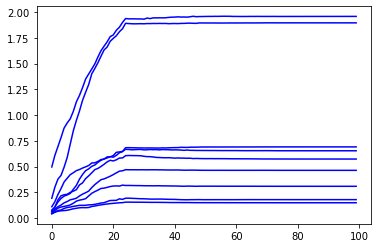

In [223]:
[plt.plot([x for x in range(100)],by_layer[l],  '-k', color='blue') for l in range(9)]

In [225]:
(baseline.avg_weight_history[99]['model.1.0.weight'])

tensor([[[[-1.1096e-01, -1.2329e-01, -1.1084e-01],
          [-1.2993e-01, -1.1098e-01, -1.3594e-01],
          [-6.7381e-02, -1.4634e-02,  2.8533e-02]],

         [[-7.7981e-02, -2.1578e-03,  2.3003e-02],
          [-1.2117e-01, -5.7711e-02, -1.4878e-02],
          [-2.5713e-01, -2.0143e-01, -1.0216e-01]],

         [[-4.3915e-03, -1.9280e-02, -2.8378e-02],
          [-4.6765e-02, -8.1947e-02, -5.1299e-02],
          [-6.9307e-02, -2.1950e-01, -2.1353e-01]],

         ...,

         [[-1.8569e-01, -1.2538e-01, -1.2118e-01],
          [ 3.3761e-02, -2.9584e-02,  2.6167e-02],
          [-3.0270e-02, -6.6300e-02,  1.9905e-02]],

         [[-5.8725e-02, -6.0506e-02, -7.6131e-02],
          [ 4.1337e-02, -1.2399e-02,  3.5790e-02],
          [ 4.3396e-02, -1.9127e-02, -1.2670e-01]],

         [[ 1.0694e-01,  8.9551e-02,  9.3676e-02],
          [ 2.4335e-01,  3.2137e-01,  3.1068e-01],
          [ 1.2739e-01,  1.9844e-01,  1.4244e-01]]],


        [[[ 8.1267e-02,  1.1858e-01,  2.5228e-02],
  